In [131]:
import pandas as pd

# Load stock data (replace with your file)
df = pd.read_csv("AAPL.csv", index_col="Date", parse_dates=True)

# Display dataset summary
print("🔹 Dataset Overview:\n", df.info())

print ("***********************************")

# Display first few rows
print("\n🔹 Data Head:\n", df.head())
print ("***********************************")
# Check for missing values
print("\n🔹 Missing Values:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 2024-03-26 00:00:00-04:00 to 2025-03-26 00:00:00-04:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          251 non-null    float64
 1   High          251 non-null    float64
 2   Low           251 non-null    float64
 3   Close         251 non-null    float64
 4   Volume        251 non-null    int64  
 5   Dividends     251 non-null    float64
 6   Stock Splits  251 non-null    float64
 7   Ticker        251 non-null    object 
dtypes: float64(6), int64(1), object(1)
memory usage: 17.6+ KB
🔹 Dataset Overview:
 None
***********************************

🔹 Data Head:
                                  Open        High         Low       Close  \
Date                                                                        
2024-03-26 00:00:00-04:00  169.201060  170.614385  168.783036  168.912430   
2024-03-27 00:00:00-04:00  169.609134  172.784144  169

In [132]:
# Drop rows with missing values
df.dropna(inplace=True)

# OR Fill missing values using forward-fill (last known value)
df.fillna(method='ffill', inplace=True)

# Check again for missing values
print("\n🔹 Missing Values After Cleaning:\n", df.isnull().sum())



🔹 Missing Values After Cleaning:
 Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Ticker          0
dtype: int64


/tmp/ipykernel_23480/329855475.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [133]:
import numpy as np

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply to key columns
df = remove_outliers(df, "Close")
df = remove_outliers(df, "Volume")


In [134]:
diff_close_series = df['Close'].diff().dropna()

In [135]:
# Create lagged features from differences
lagged_data = pd.concat(
    [diff_close_series.shift(i) for i in range(2, -1, -1)],
    axis=1
).dropna()
lagged_data.columns = [f'lag_{i}' for i in range(2, -1, -1)]

In [136]:
# Split into 50% train and 50% test
split_idx = int(len(lagged_data) * 0.8)
train_data = lagged_data.iloc[:split_idx]
test_data = lagged_data.iloc[split_idx:]

In [137]:
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [138]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [139]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [202]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Input ,GRU 
from tensorflow.keras.optimizers import Adagrad ,Adadelta ,Adam

In [203]:
# Define and compile the GRU model
model = Sequential()
model.add(Input(shape=(X_train_reshaped.shape[1], 1)))  # Explicit input layer
model.add(GRU(50, return_sequences=False))  # GRU instead of LSTM
model.add(LeakyReLU(negative_slope=0.01))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [204]:
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=16, verbose=1)


Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9665  
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9443 
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9627 
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1388 
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9890 
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9828 
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9490 
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8470 
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9043 
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2212 
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1344 
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1746 
Epoch 13/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1329 
Epoch 14/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8446 
Epoch 15/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

In [205]:
from sklearn.metrics import mean_squared_error, r2_score

y_train_pred_scaled = model.predict(X_train)
y_test_pred_scaled = model.predict(X_test)

# Inverse transform predictions
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Evaluate performance
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [206]:
print(f"Train MSE: {mse_train:.6f}")
print(f"Train R2: {r2_train:.6f}")
print(f"Test MSE: {mse_test:.6f}")
print(f"Test R2: {r2_test:.6f}")

Train MSE: 13.708043
Train R2: -0.408547
Test MSE: 33.442135
Test R2: -0.381432


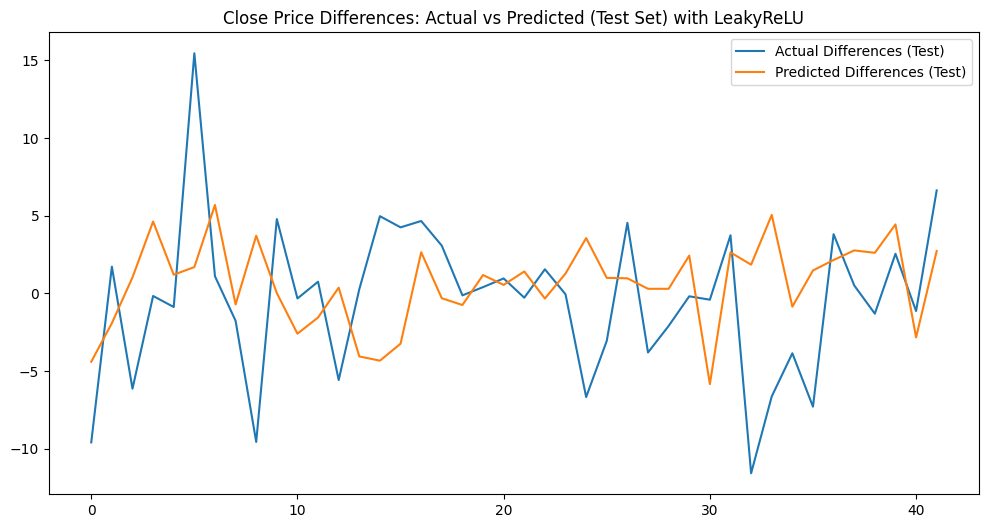

In [207]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Differences (Test)')
plt.plot(y_test_pred, label='Predicted Differences (Test)')
plt.title("Close Price Differences: Actual vs Predicted (Test Set) with LeakyReLU")
plt.legend()
plt.show()